# Linear Regression

In [1]:
%run -m ipy_startup
%matplotlib inline
from scipy.stats import norm

In [2]:
# Generate random data to model
np.random.seed(1)
n, n_var = 10000, 10
positive_only = False
#n, n_class, n_var = 10000, 4, 5

X = np.random.randn(n, n_var)

b_act = np.random.randn(n_var)
b_int = -.3

ym = b_int + np.dot(X, b_act)

y = norm.rvs(ym, .1)
if positive_only:
    y = np.exp(y)

X.shape, y.shape

((10000, 10), (10000,))

In [3]:
pd.Series(y).describe()

count    10000.000000
mean        -0.318699
std          2.932502
min        -10.235781
25%         -2.297516
50%         -0.308880
75%          1.641000
max         11.612354
dtype: float64

In [4]:
from ml.scipy import optimize, models
from ml.sklearn.preprocessing import MeanScaler

param_names = ['X{}'.format(i) for i in range(n_var)]
constraints = optimize.ScipyConstraints()
lam = 5.
constraints.add_l2_regularization(param_names, lam)
#constraints.add_l2_regularization(param_names[5:], 10.)
constraints.add_gtez('X0')
constraints.add_gte('X0', 'X1')
# constraints.add_gte('X0', 'X2')
# constraints.add_gte('X2', 'X3')
#constraints.add_gtev('X4', 5.0)


model = (
    models.ScipyLinearRegressionModelBuilder()
    .add_linear_params(param_names)
    .add_intercept()
#     .set_y_scaler(MeanScaler())
    .add_constraints(constraints)
    .build()
)


In [5]:
%%time
est = optimize.ScipyRegressor(model, analytical_gradients=True, monitor_gradient=True, raise_on_failure=False)
est.fit(X, y)

CPU times: user 49.2 ms, sys: 9.92 ms, total: 59.2 ms
Wall time: 15.7 ms


In [6]:
print(est.get_fit_summary())

Optimization converged successfully:

    Success: True
    Status Code: 0
    Message: Optimization terminated successfully.
    Number of iterations: 4
    Number of function evaluations: 7
    Objective Function Value: 5.514360274591712
    


In [7]:
est.get_gradient_error_history()

array([  2.56533251e-07,   1.68283908e-07,   2.53144707e-07,
         1.15702741e-07])

In [8]:
est.fit_

     fun: 5.514360274591712
     jac: array([ -3.22217476e-06,   4.55271352e+00,  -1.26600154e+00,
         3.97939137e-06,  -1.43251387e-05,   4.56713756e-06,
         8.47990125e-06,  -2.41997551e-06,   1.12047814e-05,
        -2.57841110e-06,  -3.41877371e-06])
 message: 'Optimization terminated successfully.'
    nfev: 7
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ -3.27721013e-01,   5.73606039e-15,  -4.27711499e-16,
         1.21126669e+00,   3.24335133e-01,   3.63612627e-02,
         6.47988089e-01,   2.64856645e-01,  -1.92368828e-01,
         3.85175509e-01,   9.07148871e-01])

In [9]:
d_inf = est.inference()
d_inf

{'linear': OrderedDict([('X0', 5.7360603920000845e-15), ('X1', -4.2771149906512107e-16), ('X2', 1.2112666941773342), ('X3', 0.3243351330499572), ('X4', 0.036361262659349788), ('X5', 0.64798808903480343), ('X6', 0.26485664455456831), ('X7', -0.19236882801001329), ('X8', 0.38517550946595852), ('X9', 0.90714887139014078)]), 'fit': OrderedDict(), 'intercept': OrderedDict([('intercept', -0.32772101309997137)])}

In [11]:
est.influence(d_inf, pd.DataFrame(X).add_prefix('X').iloc[0])

X0    9.317343e-15
X1    2.616553e-16
X2   -6.397569e-01
X3   -3.480014e-01
X4    3.146731e-02
X5   -1.491370e+00
X6    4.621250e-01
X7    1.464325e-01
X8    1.228860e-01
X9   -2.262161e-01
dtype: float64

In [48]:
b_int, d_inf['intercept']

(-0.3, intercept    60.376251
 dtype: float64)

In [49]:
pd.DataFrame({'actual': b_act, 'est': d_inf['linear']})

,actual,est
X0,-2.252118,3.153181e-13
X1,0.605687,-1.007820e-13
X2,1.183385,7.417174e+01
X3,0.328989,3.233524e+01
X4,0.063897,1.187035e+01
X5,0.656272,3.507556e+01
X6,0.229844,9.506805e+00
X7,-0.176799,-2.228239e+01
X8,0.396847,3.198034e+01
X9,0.938709,5.580360e+01


In [129]:
# Use this: https://stats.stackexchange.com/questions/190993/how-to-find-regression-coefficients-beta-in-ridge-regression
# to see if there is some way to figure out what alpha should be for ridge (based on lambda above) 
# to make estimates the same (and check that they are equivalent)
# *Answer = This doesn't seem to work -- coefs don't come out the same

from sklearn.linear_model import LinearRegression
est_lin = LinearRegression(fit_intercept=False).fit(X, y)
alpha = np.sqrt(np.dot(est_lin.coef_, est_lin.coef_) / lam) - 1
print('alpha = ', alpha)

from sklearn.linear_model import Ridge
est_ridge = Ridge(alpha=alpha, fit_intercept=False).fit(X, y)
est_ridge.coef_

0.62184922973156098

In [131]:
def compare(v_est, v_act):
    plt.scatter(v_est, v_act)
    vmin, vmax = v_act.min(), v_act.max()
    plt.xlim(vmin - .1, vmax + .1)
    plt.ylim(vmin - .1, vmax + .1)

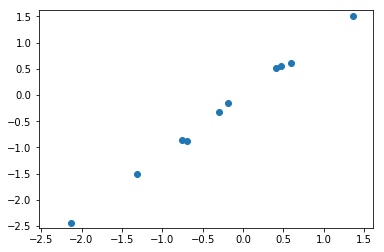

In [132]:
compare(pd.Series(d_inf['linear']), b_act)

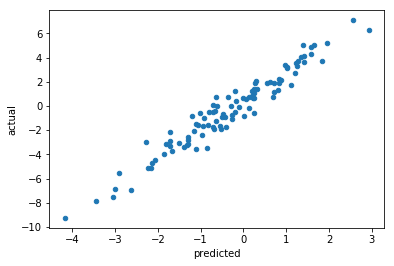

In [48]:
pd.DataFrame({
    'predicted': est.predict(X),
    'actual': y
}).plot(kind='scatter', x='predicted', y='actual')

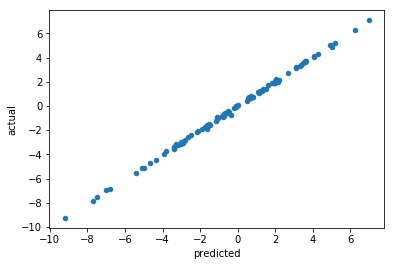

In [49]:
#from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor
pd.DataFrame({
    'predicted': GradientBoostingRegressor().fit(X, y).predict(X),
    'actual': y
}).plot(kind='scatter', x='predicted', y='actual')